# Wave Equation Neural Network incorporating Spatial Dependence

Add complexity to the neural network to see how it performs. Aiming to solve the 1D wave equation:

\begin{align*}
\frac{\partial^2 y}{\partial t^2}  = c^2 \frac{\partial^2 y}{\partial x^2}
\end{align*}

using the feed-forward neural network from the DHO solution. By using the appropriate boundary conditions, this equation describes a fixed string starting from rest $\left(\dot{y} \left(x, 0\right) = 0\right)$ with some initial profile, $y_0(x)$, the full solution to which is:

\begin{align*}
y\left(x, t \right) = \sum_{n=1}^{\infty}{b_n\cos{\left(\frac{cn\pi}{L} t\right)}\sin{\left(\frac{n\pi}{L} x\right)}}
\end{align*}

where the string is fixed at $y=0$ for $x=0$ and $x=L$ $\left(y \left(0, t\right) = y\left(L, t \right) = 0\right)$, $n$ is the mode number, $c$ is the wave speed, and the $b_n$ are the sine fourier coefficients for a periodic function of period $2L$ and are determined by the initial profile $y_0$. This script will focus on excitation of the first mode where $b_n = 0$ for $n\neq 1$ and $b_1 = A$, where $A$ is the amplitude of the wave. Thus the function being approximated is:

\begin{align*}
y\left(x, t\right) = A\cos{\left(\frac{c \pi}{L} t\right)} \sin{\left(\frac{\pi x}{L}\right)}
\end{align*}

In [13]:
import torch as t
import numpy as np 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
import random

In [14]:
def analytical(t, x, c, L, A):
    """t- Time array, x- Position array, c- wave speed, L- Length of string, A- Amplitude"""
    k = np.pi/L
    return A*np.cos(c*k*t)*np.sin(k*x)

n_points = 99
time = np.linspace(0, 1, n_points)
space = np.linspace(0, 1, n_points)
c = 1
L = 1
A = 1

y_analytical = []
for ti in time:
    ti_sol = analytical(ti, space, c, L, A)
    y_analytical.append(ti_sol)

y_analytical = np.array(y_analytical)
print(y_analytical.shape)

plt.figure(figsize=(6, 6))
plt.contourf(space, time, y_analytical, levels=np.linspace(np.min(y_analytical),np.max(y_analytical),500), cmap=plt.cm.turbo)
plt.xlabel('x', fontsize = 15)
plt.ylabel('t', fontsize = 15)
plt.title(r'Analytical $y(x,t)$', fontsize = 20)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize = 12)
cbar.set_label(label='y(x,t)', size=15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'1+1Figures/1+1Analytical.png', format = 'png')
plt.clf()

(99, 99)


<Figure size 600x600 with 0 Axes>

Plot follows BCs and ICs well as well as the time evolution you'd expect from the symmetry of the system.

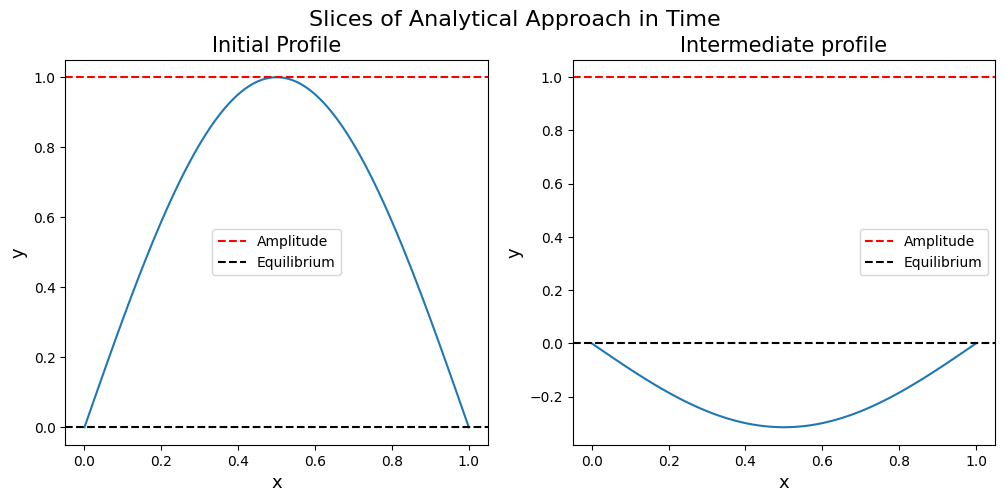

In [15]:
#Slice heat map in time
initial = y_analytical[0]
slice = y_analytical[int(len(y_analytical)*0.6)]

plt.figure(figsize = [12, 5])
plt.suptitle('Slices of Analytical Approach in Time', fontsize = 16)
plt.subplot(1, 2, 1)
plt.plot(space, initial)
plt.title('Initial Profile', fontsize = 15)
plt.axhline(1, linestyle = '--', color = 'r', label = 'Amplitude')
plt.axhline(0, linestyle = '--', color = 'k', label = 'Equilibrium')
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(space, slice)
plt.title('Intermediate profile', fontsize = 15)
plt.axhline(1, linestyle = '--', color = 'r', label = 'Amplitude')
plt.axhline(0, linestyle = '--', color = 'k', label = 'Equilibrium')
plt.xlabel('x', fontsize = 13)
plt.ylabel('y', fontsize = 13)
plt.legend()
plt.show()



In [16]:
#Create Neural Network architecture
class Model(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, num_hidden_layers=2):
        super().__init__() 
        self.input_layer = nn.Linear(in_channels, hidden_channels)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_channels, hidden_channels) for _ in range(num_hidden_layers)]) 
        self.output_layer = nn.Linear(hidden_channels, out_channels) 

    def forward(self, x: t.tensor):
        #x is a tensor with shape [batch_size, in_channels]
        x = F.tanh(self.input_layer(x)) 
        #x leaves as tensor with shape [batch_size, hidden_channels]
        for hidden_layer in self.hidden_layers:
            x = F.tanh(hidden_layer(x))
        #x leaves as tensor with shape [batch_size, output_channels]
        x = self.output_layer(x) 
        return x 

In [ ]:
#Prep inputs
time = np.linspace(0, 1, n_points)
space = np.linspace(0, L, n_points)
t_mesh, x_mesh = np.meshgrid(time, space)
tx = t.tensor(np.stack([t_mesh.flatten(), x_mesh.flatten()], axis = 1), dtype = t.float32, requires_grad = True)

x_IC = np.linspace(0, L, n_points) #x array 
t_IC = np.zeros_like(x_IC) #zero array
tx_IC = t.tensor(np.stack([t_IC, x_IC], axis = 1), dtype = t.float32, requires_grad=True)

t_BC = np.linspace(0, 1, n_points)
x_BC1 = np.zeros_like(t_BC)
x_BC2 = L*np.ones_like(t_BC)
tx_BC1 = t.tensor(np.stack([t_BC, x_BC1], axis = 1), dtype = t.float32, requires_grad = True)
tx_BC2 = t.tensor(np.stack([t_BC, x_BC2], axis = 1), dtype = t.float32, requires_grad = True)
y_IC_target = A*np.sin(np.pi*x_IC/L)
y_IC_target = t.tensor(y_IC_target, dtype = t.float32).reshape(-1, 1)

#Define loss and optimiser
learning_rate = 1e-3
model = Model(2, 1, 32)
optimiser = optim.Adam(model.parameters(), lr = learning_rate)
loss_final = []

number_iterations = 10000
for epoch in range(number_iterations):
    optimiser.zero_grad()

    y_predictedIC = model(tx_IC)
    loss_yIC = t.mean((t.squeeze(y_predictedIC) - t.squeeze(y_IC_target))**2)
    dydt_predictedIC = t.autograd.grad(y_predictedIC, tx_IC, t.ones_like(y_predictedIC), create_graph = True)[0][:,0]
    loss_dyIC = t.mean((t.squeeze(dydt_predictedIC) - 0)**2)

    y_predictedBC1 = model(tx_BC1)
    loss_BC1 = t.mean((t.squeeze(y_predictedBC1) - 0)**2)
    y_predictedBC2 = model(tx_BC2)
    loss_BC2 = t.mean((t.squeeze(y_predictedBC2) - 0)**2)

    y_predicted = model(tx)
    grads = t.autograd.grad(y_predicted, tx, t.ones_like(y_predicted), create_graph = True)[0]
    dydt = grads[:, 0:1]
    dydx = grads[:, 1:2]

    d2ydt2 = t.autograd.grad(dydt, tx, t.ones_like(dydt), create_graph = True)[0][:, 0:1]
    d2ydx2 = t.autograd.grad(dydx, tx, t.ones_like(dydx), create_graph = True)[0][:, 1:2]

    loss_physics = t.mean((d2ydt2 - c**2*d2ydx2)**2)

    loss = loss_BC1 + loss_BC2 + loss_dyIC + 10*loss_physics + 15*loss_yIC
    with t.no_grad():
        loss_final.append(loss.detach().numpy())
    loss.backward()
    optimiser.step()


    if (epoch + 1) % 2000 == 0 or epoch == 0:
            print(f"""Epoch: {epoch + 1} / {number_iterations}. Total loss: {loss:.4e}, 
                        y(0) loss: {loss_yIC:.4e},
                        dydt(0) loss: {loss_dyIC:.4e}, 
                        x = 0 loss: {loss_BC1:.4e}, 
                        x = L loss: {loss_BC2:.4e},
                        physics loss: {loss_physics:.4e}""")
            y = model(tx)
            y = y.reshape(n_points, -1).detach().numpy()
            y = y.transpose()
            plt.figure(figsize=(6, 6))
            plt.contourf(space, time, y, levels=np.linspace(np.min(y_analytical),np.max(y_analytical), 500), cmap=plt.cm.turbo)
            plt.xlabel('x', fontsize = 15)
            plt.ylabel('t', fontsize = 15)
            plt.suptitle(f'Epoch: {epoch + 1}, total scaled loss: {loss:.4e}', fontsize = 20)
            cbar=plt.colorbar()
            cbar.ax.tick_params(labelsize = 12)
            cbar.set_label(label='y(x,t)', size=15)
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            plt.savefig(f'1+1Figures/1+1Epoch{epoch + 1}.png', format = 'png')
            plt.clf()

            plt.figure(figsize=(6, 6))
            plt.contourf(space, time, 10e2*np.abs(y - y_analytical), levels= 10e2*np.linspace(0, np.max(np.abs(y - y_analytical)), 500), cmap=plt.cm.turbo)
            plt.xlabel('x', fontsize = 15)
            plt.ylabel('t', fontsize = 15)
            plt.suptitle(r'Scaled Residuals: $10^{2} \left| y_{NN} - y_{analytical}\right|$', fontsize = 20)
            cbar=plt.colorbar()
            cbar.ax.tick_params(labelsize = 12)
            cbar.set_label(label='y(x,t)', size=15)
            ax = plt.gca()
            ax.set_aspect('equal', adjustable='box')
            plt.savefig(f'1+1Figures/1+1ScaledResiduals{epoch + 1}.png', format = 'png')
            plt.clf()

    if (epoch + 1) == number_iterations:
        print("Training complete.")

Epoch: 1 / 10000. Total loss: 6.2876e+00, 
                        y(0) loss: 4.1589e-01,
                        dydt(0) loss: 1.8075e-02, 
                        x = 0 loss: 1.7137e-03, 
                        x = L loss: 1.3536e-03,
                        physics loss: 2.8179e-03


Minimum and maximum values:  -0.9959632 0.9975863
Mean square difference:  4.388911649110044e-05


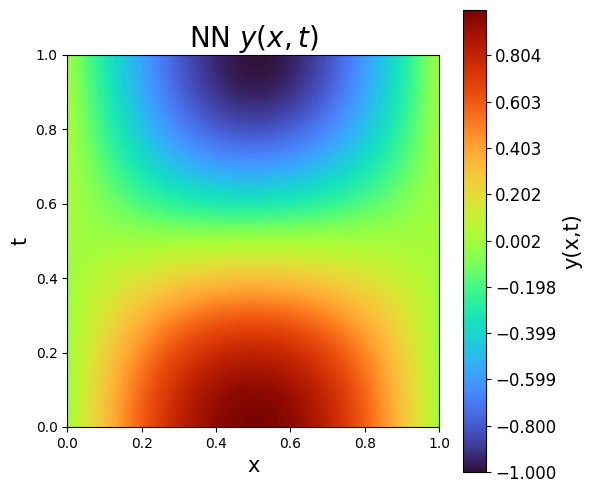

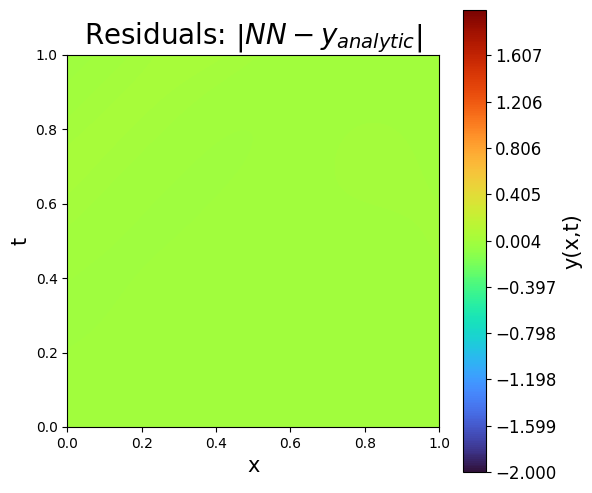

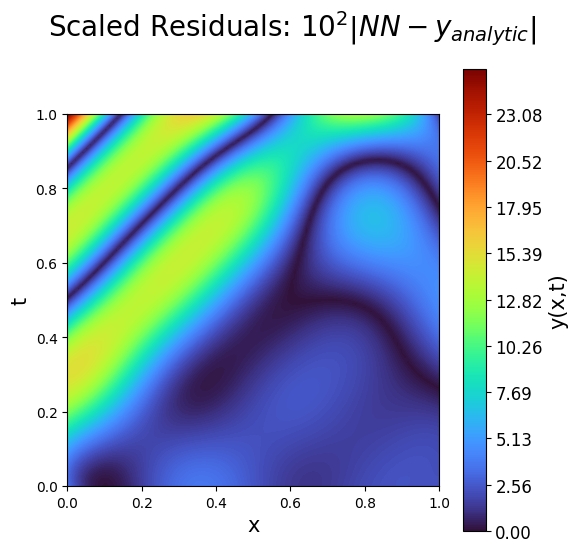

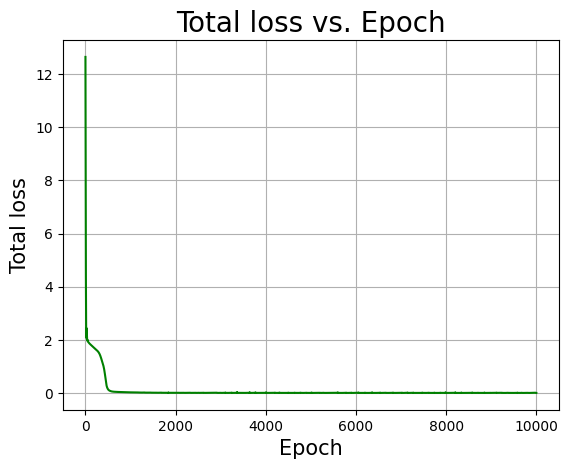

In [ ]:
y_nn = model(tx)
y_nn = y_nn.reshape(n_points, -1).detach().numpy()
y_nn = y_nn.transpose()
print("Minimum and maximum values: ", np.min(y_nn), np.max(y_nn))
print("Mean square difference: ", np.mean((y_nn - y_analytical)**2))
epoch_axis = np.linspace(0, number_iterations, number_iterations)

plt.figure(figsize=(6, 6))
plt.contourf(space, time, y_nn, levels=np.linspace(np.min(y_analytical),np.max(y_analytical), 500), cmap=plt.cm.turbo)
plt.xlabel('x', fontsize = 15)
plt.ylabel('t', fontsize = 15)
plt.title(r'NN $y(x,t)$', fontsize = 20)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize = 12)
cbar.set_label(label='y(x,t)', size=15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(6, 6))
plt.contourf(space, time, (y_nn - y_analytical), levels=np.linspace(-2, 2, 500), cmap=plt.cm.turbo)
plt.xlabel('x', fontsize = 15)
plt.ylabel('t', fontsize = 15)
plt.title(r'Residuals: $\left|NN - y_{analytic} \right|$', fontsize = 20)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize = 12)
cbar.set_label(label='y(x,t)', size=15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

plt.figure(figsize=(6, 6))
plt.contourf(space, time, 10e2*np.abs(y_nn - y_analytical), levels=10e2*np.linspace(np.min(np.abs(y_nn-y_analytical)), np.max(np.abs(y_nn-y_analytical)), 500), cmap=plt.cm.turbo)
plt.xlabel('x', fontsize = 15)
plt.ylabel('t', fontsize = 15)
plt.suptitle(r'Scaled Residuals: $10^{2} \left|NN - y_{analytic}\right|$', fontsize = 20)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize = 12)
cbar.set_label(label='y(x,t)', size=15)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

plt.figure()
plt.plot(epoch_axis, loss_final, color = 'green')
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Total loss', fontsize = 15)
plt.title('Total loss vs. Epoch', fontsize = 20)
plt.grid()
plt.savefig('1+1Figures/Loss vs t.png', format = 'png')
plt.clf()
